# Capstone Project- The Battle of the Neighborhoods (Week 2)

## Applied Data Science Capstone 

### By: Chris Cothran

### Table of Contents

I.	Context <br>
II.	Business Problem <br>
III.	Data <br>
IV.	Data Preparation, Wrangling and Exploratory Data Analysis <br>
V.	Area Analysis <br>
VI.	Foursquare Data Selection <br>
VII.	Methodology <br>
VIII.	Candidate Selection Analysis <br>
IX.	K-Means Clustering <br>

### I. Context

Each year, millions of homes are sold, constructed, or are renovated or repaired. These processes require materials, parts, and expertise that home improvement retailers can provide. The importance of siting a store to garner revenue from all of these activities while being sufficiently distant from competitors so that local activities increasingly rely on your store is one of many factors a company may consider in determining where to locate a new store. It provides a home improvement retailer extensive benefit to be able to predict where optimal zones to build a new store might be. This information can then be incorporated into a wide range of other factors to yield a final business decision. 

### II. Business Problem

In this project we will try to derive a high-graded list of optimal locations for a home improvement retailer. This report will be targeted to stakeholders considering expansion into the home improvement retail market in Houston, Texas, USA. There are multiple well-established home improvement retailers operating in Houston. For this initial exercise, we will consider optimality as a function in part derived from proximity to zones of higher home construction, renovation, and maintenance spending and distance from competing home improvement retail stores. The stakeholders are likely interested in zones that may be underserved in this regard in multiple categories as ideal locations. However, assuming the optimal conditions are met, we would like to locate the store as close to high-population zones within the city to ensure adequate day-to-day foot traffic.

### III. Data

For this project, I will source data from the following locations: Foursquare, The U.S. Census Bureau, the U.S. Internal Revenue Service, the National Association of Realtors, and Foursquare. <br>

1)	Foursquare shall provide the data for the number of existing home improvement retailers in a city neighborhood, distance of neighborhoods from concentrated population zones, and proximity of existing shopping centers for convenience of access.<br>
2)	National Association of Realtor’s data provided from Realtor.com shall provide number of housing listings by zip code.<br>
3)	U.S. Internal Revenue Service shall provide population data by zip code used to determine density proximity to potential sites based on number of filed income tax returns. <br>
4)	U.S. Internal Revenue Service data for two subsequent years shall provide economic growth indications based on the number of returns by income level in a given zip code year-over-year.<br>
5) City center coordindates provided by Opendatasoft<br>

### IV. Data Preparation, Wrangling and Exploratory Data Analysis

In [1]:
#install Necessary Libraries

!pip install shapely
!pip install pyproj
!pip install wget
!pip install folium

     |████████████████████████████████| 1.0MB 10.2MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 5.3MB/s eta 0:00:01    |████████████████████████████▊   | 9.8MB 5.3MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 102kB 10.5MB/s ta 0:00:01


In [2]:
#import Libraries needed in the Project

import pandas as pd
import numpy as np
import wget
import folium
import geopy
import sklearn
import pylab as pl
import seaborn as sns
import matplotlib as mp
import matplotlib.cm as cm
import matplotlib.colors as colors
import random
import json
import requests
import scipy.optimize as opt
from geopy.geocoders import Nominatim
from matplotlib.ticker import NullFormatter
from matplotlib import pyplot as plt
from pandas.io.json import json_normalize
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Lets set options to see maximum Columns and Rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Get the datasets from the web

In [3]:
# we will define the urls for each of the downloadable files

url_NAR='https://github.com/Empcoth/Coursera_Capstone/raw/master/NAR2020.xlsx'
url_GOV_2017= 'https://github.com/Empcoth/Coursera_Capstone/raw/master/2017IRS.xls'

In [4]:
#use the get library to download into local files

NAR=wget.download(url_NAR,r'\Users\Chris\Downloads\NAR.xlsx')
GOV_2017=wget.download(url_GOV_2017,r'\Users\Chris\Downloads\GOV_2017.xls')

In [5]:
#convert the files into pandas dataframes
NAR_df=pd.read_excel(r'\Users\Chris\Downloads\NAR.xlsx')

#As the columns have Mixed Data types, We specify these are parameters during the read_excel process
GOV_2017_df=pd.read_excel(r'\Users\Chris\Downloads\GOV_2017.xls',dtype={"ZIP":str, "Adjusted Gross Income":str, "Number of returns":int})

In [6]:
#Look at the Shape of the Downloaded Files
print('The NAR July 2020 Data Consists of (Rows, Columns)', NAR_df.shape)
print('The IRS 2017 Data Consists of (Rows, Columns)', GOV_2017_df.shape)

The NAR July 2020 Data Consists of (Rows, Columns) (99286, 20)
The IRS 2017 Data Consists of (Rows, Columns) (9720, 3)


In [7]:
#Save each NAR dataframe to the defined set of columns needed for this project
NAR_df=NAR_df[['postal_code','month_date_yyyymm','median_listing_price','active_listing_count']]

In [8]:
#Again Look at the Shape of the Downloaded Files
print('The NAR July 2020 Data Consists of (Rows, Columns)', NAR_df.shape)
print('The IRS 2017 Data Consists of (Rows, Columns)', GOV_2017_df.shape)

The NAR July 2020 Data Consists of (Rows, Columns) (99286, 4)
The IRS 2017 Data Consists of (Rows, Columns) (9720, 3)


In [9]:
NAR_df.dtypes

postal_code               int64
month_date_yyyymm         int64
median_listing_price    float64
active_listing_count      int64
dtype: object

In [10]:
GOV_2017_df.dtypes

ZIP                      object
Adjusted Gross Income    object
Number of returns         int64
dtype: object

### We now download a file of Texas Longitude and Latitude coordinates and save it to a pandas dataframe

In [11]:
coord='https://raw.githubusercontent.com/Empcoth/Coursera_Capstone/master/LongLat.csv'
coordinates=wget.download(coord,r'\Users\Chris\Downloads\LongLat2.csv')

In [12]:
coor_df=pd.read_csv(r'\Users\Chris\Downloads\LongLat2.csv')

In [13]:
coor_df.head()

,Zip,City,Latitude,Longitude
0,75016,Irving,32.767268,-96.777626
1,76385,Vernon,34.146356,-99.214088
2,77320,Huntsville,30.805099,-95.507190
3,77449,Katy,29.825908,-95.730100
4,76651,Italy,32.175783,-96.880180


## V. Area Analysis

### Now we will define the Houston area and look at the preliminary map using the Folium Library

In [14]:
#Define a dataframe with only City of Houston Coordinates to Find the City Center
Houston_df = coor_df.loc[coor_df['City'] =='Houston'] 
CityCenter_df=Houston_df.loc[Houston_df['Zip'] ==77002]  

In [15]:
CityCenter_df.head()

,Zip,City,Latitude,Longitude
1361,77002,Houston,29.755578,-95.36531


In [16]:
latitude=CityCenter_df['Latitude'][1361]
longitude=CityCenter_df['Longitude'][1361]

In [17]:
#Output of City Center Derivation
latitude, longitude

(29.755578000000003, -95.36531)

In [18]:
#Define a Folium Map Object Variable
map_houston = folium.Map(location=[latitude, longitude], zoom_start=10)

In [19]:
#Display the Map
map_houston

#### We need to include the greater metro area beyond Houston city limits in this analysis to be effective with this study. Thus, we will first define the 'Greater Houston' area with a list of Zip Codes traditionally included in that designation

In [20]:
#Import dataset of relevant zip codes

houzip='https://github.com/Empcoth/Coursera_Capstone/raw/master/HoustonAreaLongLat.xlsx'
houcord=wget.download(houzip,r'\Users\Chris\Downloads\HoustonAreaLongLat2.xlsx')

In [21]:
#Convert imported data to a pandas dataframe
hou_zip_df=pd.read_excel(r'\Users\Chris\Downloads\HoustonAreaLongLat2.xlsx')

In [22]:
#Look at the dataframe
hou_zip_df.head()

,Zip
0,77002
1,77003
2,77004
3,77005
4,77006


In [23]:
#Look at the dataframe shape
hou_zip_df.shape

(236, 1)

In [24]:
#Check to see if Houston metro zips are in the Main List, to curate a list of Houston Metro Zip Codes and their Corresponding Longitude and Latitude Values in a Combined List
new_coor = coor_df.assign(result=coor_df['Zip'].isin(hou_zip_df['Zip']).astype(int))
test_coor=new_coor[new_coor['result']==1]
test_coor.drop(['result'], axis=1, inplace=True)
test_coor.reset_index(drop=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Zip,City,Latitude,Longitude
0,77449,Katy,29.825908,-95.730100
1,77034,Houston,29.636430,-95.217890
2,77003,Houston,29.749278,-95.347410
3,78933,Cat Spring,29.773128,-96.393420
4,77479,Sugar Land,29.573345,-95.632130
5,77042,Houston,29.741565,-95.559960
6,77091,Houston,29.852975,-95.435860
7,77083,Houston,29.691714,-95.649780
8,77417,Beasley,29.483573,-95.939310
9,77033,Houston,29.669130,-95.338340


### Create a map of Houston with zip code centerpoints superimposed on top

In [25]:
#add markers to map
for lat, lng, Zip, city in zip(test_coor['Latitude'],test_coor['Longitude'],test_coor['Zip'],test_coor['City']):
    label='{}, {}'.format(Zip, city)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston)

In [26]:
map_houston

### We will now define viability ratings based on real estate listings and zip code performance

In [27]:
NAR_df.head()

,postal_code,month_date_yyyymm,median_listing_price,active_listing_count
0,67801,202007,154050.0,26
1,34436,202007,263050.0,31
2,77423,202007,307550.0,89
3,84103,202007,849500.0,69
4,84027,202007,249050.0,13


#### Let's get a Year-to-Date Active Listing Count by Zip code in the Defined Greater Houston Metropolitan Area

In [28]:
#Define the Zip Codes into a Filtered Dataframe
test_nar_df=NAR_df.assign(result=NAR_df['postal_code'].isin(hou_zip_df['Zip']).astype(int))
NAR_filtered_df=test_nar_df[test_nar_df['result']==1]
NAR_filtered_df.drop(['result'], axis=1, inplace=True)
NAR_filtered_df.reset_index(drop=True).head()

,postal_code,month_date_yyyymm,median_listing_price,active_listing_count
0,77423,202007,307550.0,89
1,77021,202007,292050.0,95
2,77532,202007,241495.0,132
3,77489,202007,189050.0,29
4,77069,202007,298750.0,88


In [29]:
#Lets Create a Composite Factor Based on median_listing_price multiplied by active_listing_count
import warnings
warnings.filterwarnings('ignore')
NAR_filtered_df['investment intensity']=NAR_filtered_df['median_listing_price']*NAR_filtered_df['active_listing_count']
NAR_filtered_df.reset_index(drop=True, inplace=True)
NAR_filtered_df.head()

,postal_code,month_date_yyyymm,median_listing_price,active_listing_count,investment intensity
0,77423,202007,307550.0,89,27371950.0
1,77021,202007,292050.0,95,27744750.0
2,77532,202007,241495.0,132,31877340.0
3,77489,202007,189050.0,29,5482450.0
4,77069,202007,298750.0,88,26290000.0


In [30]:
NAR_grouped=NAR_filtered_df.groupby('postal_code').sum().reset_index()
NAR_grouped.head()

,postal_code,month_date_yyyymm,median_listing_price,active_listing_count,investment intensity
0,77002,1414028,2212700.0,409,1.289000e+08
1,77003,1414028,2630900.0,766,2.878397e+08
2,77004,1414028,2583894.5,1502,5.545900e+08
3,77005,1414028,10130750.0,1134,1.644198e+09
4,77006,1414028,4327950.0,1144,7.071631e+08


In [31]:
#We can remove the date, listing price, and active listing columns
NAR=NAR_grouped.drop(columns=['month_date_yyyymm','median_listing_price','active_listing_count'])
NAR['investment intensity']=NAR['investment intensity'].div(1000000)
#As the Investment Intensity is quite large, we can Divide by 1 million to make it more manageable while retaining relative difference across postal codes
NAR.head()

,postal_code,investment intensity
0,77002,128.900050
1,77003,287.839725
2,77004,554.590012
3,77005,1644.197700
4,77006,707.163100


### We will now define viability ratings based on combined filings times income factors for each zip code

In [32]:
GOV_2017_df.head()

,ZIP,Adjusted Gross Income,Number of returns
0,75001,"$1 under $25,000",2370
1,75001,"$25,000 under $50,000",2440
2,75001,"$50,000 under $75,000",1680
3,75001,"$75,000 under $100,000",940
4,75001,"$100,000 under $200,000",1320


#### We should take a look at adjusted gross income as it is a combination of string and integer values in the dataframe

In [33]:
#List the unique values in the Adjusted Gross Income column
print(GOV_2017_df['Adjusted Gross Income'].unique().tolist())

['$1 under $25,000', '$25,000 under $50,000', '$50,000 under $75,000', '$75,000 under $100,000', '$100,000 under $200,000', '$200,000 or more']


In [34]:
#Define a new dataframe and assign a Factor Score for each income level
GOV_df=GOV_2017_df
GOV_df['Adjusted Gross Income']=GOV_df['Adjusted Gross Income'].replace(['$1 under $25,000'],'1')
GOV_df['Adjusted Gross Income']=GOV_df['Adjusted Gross Income'].replace(['$25,000 under $50,000'],'2')
GOV_df['Adjusted Gross Income']=GOV_df['Adjusted Gross Income'].replace(['$50,000 under $75,000'],'3')
GOV_df['Adjusted Gross Income']=GOV_df['Adjusted Gross Income'].replace(['$75,000 under $100,000'],'4')
GOV_df['Adjusted Gross Income']=GOV_df['Adjusted Gross Income'].replace(['$100,000 under $200,000'],'5')
GOV_df['Adjusted Gross Income']=GOV_df['Adjusted Gross Income'].replace(['$200,000 or more'],'6')
GOV_df.head()

,ZIP,Adjusted Gross Income,Number of returns
0,75001,1,2370
1,75001,2,2440
2,75001,3,1680
3,75001,4,940
4,75001,5,1320


In [35]:
# We can then rename the Adjusted Gross Income column
GOV_df.rename(columns={'Adjusted Gross Income':'Income Level Score'},inplace=True)
#Multiply the Income Level Score by the Number of Returns for a Relative Income Factor
GOV_df['Income Level Score']=GOV_df['Income Level Score'].astype(str).astype(int)
GOV_df['income intensity']=GOV_df['Income Level Score']*GOV_df['Number of returns']
GOV_df.reset_index(drop=True, inplace=True)
GOV_df.head()

,ZIP,Income Level Score,Number of returns,income intensity
0,75001,1,2370,2370
1,75001,2,2440,4880
2,75001,3,1680,5040
3,75001,4,940,3760
4,75001,5,1320,6600


In [36]:
#We can then group by Zip
GOV_grouped=GOV_df.groupby('ZIP').sum().reset_index()
GOV_grouped.head()

,ZIP,Income Level Score,Number of returns,income intensity
0,75001,21,9340,26190
1,75002,21,30620,94080
2,75006,21,23870,56750
3,75007,21,26370,73230
4,75009,21,6710,23100


In [37]:
#And remove the Income Level Score and Number of Returns Columns
GOV=GOV_grouped.drop(columns=['Income Level Score','Number of returns'])
GOV.head()

,ZIP,income intensity
0,75001,26190
1,75002,94080
2,75006,56750
3,75007,73230
4,75009,23100


In [38]:
#Convert the Data Type of the Zip Column
GOV_Test=GOV

In [39]:
GOV_Test

,ZIP,income intensity
0,75001,26190
1,75002,94080
2,75006,56750
3,75007,73230
4,75009,23100
5,75010,43230
6,75013,69690
7,75019,71160
8,75020,22770
9,75021,8800


In [40]:
GOV_Test["ZIP"]=GOV_Test["ZIP"].astype(int)

In [41]:
GOV_Test.dtypes

ZIP                 int64
income intensity    int64
dtype: object

In [42]:
#Define the Zips per the Greater Houston Metropolitan Area

GOV_Test=GOV_Test.assign(result=GOV_Test['ZIP'].isin(hou_zip_df['Zip']).astype(int))
GOV_Test=GOV_Test[GOV_Test['result']==1]
GOV_Test.drop(['result'], axis=1, inplace=True)
GOV_Test.reset_index(drop=True).head()

,ZIP,income intensity
0,77002,20090
1,77003,15410
2,77004,35300
3,77005,52810
4,77006,45200


In [43]:
#We Can Then Define a Dataframe Combining Investment Intensity and Income Intensity by Zip

#First Lets Rename the Column Label of the NAR Df to Match the GOV DF

NAR_Renamed=NAR
NAR_Renamed.rename(columns={"postal_code": "ZIP"}, inplace=True)

In [44]:
NAR_Renamed.dtypes

ZIP                       int64
investment intensity    float64
dtype: object

In [45]:
GOV_Test.dtypes

ZIP                 int64
income intensity    int64
dtype: object

In [46]:
#We merge the Dataframes using the ZIP Key
merged_df=pd.merge(NAR_Renamed,GOV_Test, on=['ZIP','ZIP'])

In [47]:
merged_df

,ZIP,investment intensity,income intensity
0,77002,128.900050,20090
1,77003,287.839725,15410
2,77004,554.590012,35300
3,77005,1644.197700,52810
4,77006,707.163100,45200
5,77007,1414.952830,88290
6,77008,1298.130485,69340
7,77009,713.582690,44560
8,77011,55.594124,12590
9,77012,17.407400,12970


In [48]:
#We Can Then Factor the Two Values by Multiplying Them
merged_df['Prospectivity Score']=merged_df['investment intensity']*merged_df['income intensity']

In [49]:
#We Can then Normalize the Prospectivity Score
normalized_df=merged_df
normalized_df['Prospectivity Score']=(normalized_df['Prospectivity Score']-normalized_df['Prospectivity Score'].mean())/normalized_df['Prospectivity Score'].std()

In [50]:
#Sort by Prospectivity Score to Look at Top Prospects
normalized_df.sort_values(by=['Prospectivity Score'],ascending=False,inplace=True)
normalized_df.reset_index(drop=True,inplace=True)

In [51]:
#We Can then Merge the Coordinate List with the Merged DF by eliminating Zip Codes Not in the Merged List
test_coor_Renamed=test_coor
test_coor_Renamed.rename(columns={"Zip": "ZIP"}, inplace=True)

In [52]:
merge_test=pd.merge(test_coor_Renamed,normalized_df, on=['ZIP','ZIP'])

In [53]:
merge_test.head()

,ZIP,City,Latitude,Longitude,investment intensity,income intensity,Prospectivity Score
0,77449,Katy,29.825908,-95.73010,293.667520,119820,0.494914
1,77034,Houston,29.636430,-95.21789,33.587138,30460,-0.495364
2,77003,Houston,29.749278,-95.34741,287.839725,15410,-0.396448
3,77479,Sugar Land,29.573345,-95.63213,1283.715325,143880,4.828698
4,77042,Houston,29.741565,-95.55996,421.325450,47340,0.053120


## Now that we have our preliminary prospectivity table we can visualize the highly prospective zones

In [54]:
#Sort by Prospectivity Score in Descending Order and Take the Top 10 Rows
merge_test.sort_values(by=['Prospectivity Score'],ascending=False,inplace=True)
merge_test.reset_index(drop=True,inplace=True)

In [55]:
merge_test

,ZIP,City,Latitude,Longitude,investment intensity,income intensity,Prospectivity Score
0,77494,Katy,29.760833,-95.811040,1464.140459,168710,6.634928
1,77024,Houston,29.773994,-95.517710,3104.037550,74780,6.203177
2,77479,Sugar Land,29.573345,-95.632130,1283.715325,143880,4.828698
3,77433,Cypress,29.884175,-95.722190,1089.357898,126820,3.479447
4,77007,Houston,29.772627,-95.403190,1414.952830,88290,3.096075
5,77459,Missouri City,29.564347,-95.547620,1053.372022,110360,2.844592
6,77008,Houston,29.798777,-95.409510,1298.130485,69340,2.084068
7,77573,League City,29.502759,-95.089060,662.672050,131500,2.000849
8,77005,Houston,29.717529,-95.428210,1644.197700,52810,1.991826
9,77379,Spring,30.024749,-95.532150,670.548920,115730,1.724360


In [56]:
sample_df=merge_test.head(11)

In [57]:
sample_df

,ZIP,City,Latitude,Longitude,investment intensity,income intensity,Prospectivity Score
0,77494,Katy,29.760833,-95.81104,1464.140459,168710,6.634928
1,77024,Houston,29.773994,-95.51771,3104.037550,74780,6.203177
2,77479,Sugar Land,29.573345,-95.63213,1283.715325,143880,4.828698
3,77433,Cypress,29.884175,-95.72219,1089.357898,126820,3.479447
4,77007,Houston,29.772627,-95.40319,1414.952830,88290,3.096075
5,77459,Missouri City,29.564347,-95.54762,1053.372022,110360,2.844592
6,77008,Houston,29.798777,-95.40951,1298.130485,69340,2.084068
7,77573,League City,29.502759,-95.08906,662.672050,131500,2.000849
8,77005,Houston,29.717529,-95.42821,1644.197700,52810,1.991826
9,77379,Spring,30.024749,-95.53215,670.548920,115730,1.724360


In [58]:
sample_df

,ZIP,City,Latitude,Longitude,investment intensity,income intensity,Prospectivity Score
0,77494,Katy,29.760833,-95.81104,1464.140459,168710,6.634928
1,77024,Houston,29.773994,-95.51771,3104.037550,74780,6.203177
2,77479,Sugar Land,29.573345,-95.63213,1283.715325,143880,4.828698
3,77433,Cypress,29.884175,-95.72219,1089.357898,126820,3.479447
4,77007,Houston,29.772627,-95.40319,1414.952830,88290,3.096075
5,77459,Missouri City,29.564347,-95.54762,1053.372022,110360,2.844592
6,77008,Houston,29.798777,-95.40951,1298.130485,69340,2.084068
7,77573,League City,29.502759,-95.08906,662.672050,131500,2.000849
8,77005,Houston,29.717529,-95.42821,1644.197700,52810,1.991826
9,77379,Spring,30.024749,-95.53215,670.548920,115730,1.724360


In [59]:
map_sample = folium.Map(location=[latitude, longitude], zoom_start=10)

#add markers to map
for lat, lng, Zip, city in zip(sample_df['Latitude'],sample_df['Longitude'],sample_df['ZIP'],sample_df['City']):
    label='{}, {}'.format(Zip, city)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sample)

In [60]:
map_sample

In [61]:
pie_df=sample_df.set_index('ZIP')
pie_df

,City,Latitude,Longitude,investment intensity,income intensity,Prospectivity Score
ZIP,,,,,,
77494,Katy,29.760833,-95.81104,1464.140459,168710,6.634928
77024,Houston,29.773994,-95.51771,3104.037550,74780,6.203177
77479,Sugar Land,29.573345,-95.63213,1283.715325,143880,4.828698
77433,Cypress,29.884175,-95.72219,1089.357898,126820,3.479447
77007,Houston,29.772627,-95.40319,1414.952830,88290,3.096075
77459,Missouri City,29.564347,-95.54762,1053.372022,110360,2.844592
77008,Houston,29.798777,-95.40951,1298.130485,69340,2.084068
77573,League City,29.502759,-95.08906,662.672050,131500,2.000849
77005,Houston,29.717529,-95.42821,1644.197700,52810,1.991826


Text(0, 0.5, 'Prospectivity Score')

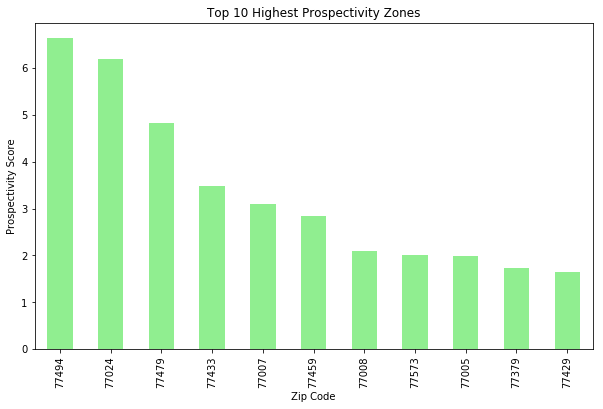

In [62]:
pie_df['Prospectivity Score'].plot(kind='bar', figsize=(10,6),rot=90, color='lightgreen')
plt.title('Top 10 Highest Prospectivity Zones')
plt.xlabel('Zip Code')
plt.ylabel('Prospectivity Score')

# VI. Foursquare Data Selection

### Next, we are going to utilize the Foursquare API to explore Home Improvement store locations in the Greater Houston Metropolitan Area

In [63]:
#Define Foursquare Credentials and Version
CLIENT_ID = '2XCT5GQNZACPUY0A1VHDEGFVHMBLP4SGF3ZARXFD21ZONABJ' # your Foursquare ID
CLIENT_SECRET = 'TYUIFCR35VAHSM3QZ5TR4FEZBVE2QHHLRPHYIC21KEM1ZGI3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude

('2XCT5GQNZACPUY0A1VHDEGFVHMBLP4SGF3ZARXFD21ZONABJ',
 'TYUIFCR35VAHSM3QZ5TR4FEZBVE2QHHLRPHYIC21KEM1ZGI3',
 '20180605',
 29.755578000000003,
 -95.36531)

In [64]:
LIMIT=100   #Limit the number of venues returned by the Forusquare API
radius=90000  #Define radius in meters from defined latitude and longitude coordinates
query='Home Depot'
#create url to access the Foursquare API
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

url2='https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    query)

url2 # display URL2

'https://api.foursquare.com/v2/venues/search?&client_id=2XCT5GQNZACPUY0A1VHDEGFVHMBLP4SGF3ZARXFD21ZONABJ&client_secret=TYUIFCR35VAHSM3QZ5TR4FEZBVE2QHHLRPHYIC21KEM1ZGI3&v=20180605&ll=29.755578000000003,-95.36531&radius=90000&limit=100&query=Home Depot'

In [65]:
#Get JSON file of the results from the API and store them in a variable
results=requests.get(url2).json()

In [66]:
results

{'meta': {'code': 200, 'requestId': '5f48fa400f769205f8035986'},
 'response': {'venues': [{'id': '4b64a942f964a5207fc62ae3',
    'name': 'The Home Depot',
    'location': {'address': '999 North Loop West',
     'lat': 29.8113638,
     'lng': -95.4171183,
     'labeledLatLngs': [{'label': 'display',
       'lat': 29.8113638,
       'lng': -95.4171183}],
     'distance': 7976,
     'postalCode': '77008',
     'cc': 'US',
     'city': 'Houston',
     'state': 'TX',
     'country': 'United States',
     'formattedAddress': ['999 North Loop West',
      'Houston, TX 77008',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d112951735',
      'name': 'Hardware Store',
      'pluralName': 'Hardware Stores',
      'shortName': 'Hardware',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/hardware_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1598618689',
    'hasPerk': False},
   {'id': '4b637497f964a520257b2ae3',
    'name': 'T

In [67]:
#see how many results were returned
counter=len(results['response']['venues'])
i=0

#Define a new dataframe to store the data
FS_df=pd.DataFrame(columns=['Hardware Store','Address','Longitude','Latitude'],index=range(101))
cols=['name','longitude','latitude']

#Iterate to read data into a dictionary
while i<counter:
    FS_df['Latitude'][i]=results['response']['venues'][i]['location']['lat']
    FS_df['Longitude'][i]=results['response']['venues'][i]['location']['lng']
    FS_df['Hardware Store'][i]=results['response']['venues'][i]['name']
    FS_df['Address'][i]=results['response']['venues'][i]['location']['formattedAddress'][0]
    i=i+1
FS_df

,Hardware Store,Address,Longitude,Latitude
0,The Home Depot,999 North Loop West,-95.4171,29.8114
1,The Home Depot,8400 Katy Freeway,-95.4936,29.7862
2,The Home Depot,5445 West Loop,-95.4573,29.7233
3,The Home Depot,18251 Gulf Freeway,-95.1532,29.5569
4,The Home Depot,10419 Highway 6 South,-95.6424,29.6638
5,The Home Depot,11500 Chimney Rock,-95.4794,29.6563
6,The Home Depot,14085 Northwest Fwy,-95.523,29.8568
7,The Home Depot,8400 Westheimer Road,-95.5146,29.739
8,The Home Depot,17928 Spring Cypress Rd,-95.6929,29.9734
9,The Home Depot,10600 Eastex Freeway,-95.3294,29.8672


### Next, we derive the locations for Lowe's, the other major Home Improvement Store covered in this Analysis

In [68]:
LIMIT=100   #Limit the number of venues returned by the Forusquare API
radius=90000  #Define radius in meters from defined latitude and longitude coordinates
query='Lowe\'s'
url3='https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    query)

#Get JSON file of the results from the API and store them in a variable
results2=requests.get(url3).json()

In [69]:
results2

{'meta': {'code': 200, 'requestId': '5f48fba784971036d5414138'},
 'response': {'venues': [{'id': '4bd9d5293f01c9b6c74e53a5',
    'name': "Lowe's",
    'location': {'address': '1521 North Loop West',
     'crossStreet': 'Ella',
     'lat': 29.8106467,
     'lng': -95.4278168,
     'labeledLatLngs': [{'label': 'display',
       'lat': 29.8106467,
       'lng': -95.4278168}],
     'distance': 8605,
     'postalCode': '77008',
     'cc': 'US',
     'city': 'Houston',
     'state': 'TX',
     'country': 'United States',
     'formattedAddress': ['1521 North Loop West (Ella)',
      'Houston, TX 77008',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d112951735',
      'name': 'Hardware Store',
      'pluralName': 'Hardware Stores',
      'shortName': 'Hardware',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/hardware_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1598618689',
    'hasPerk': False},
   {'id': '4ac9fa2ff964

In [70]:
#Let's check the length of the second request and append to the counter variable
counter=counter+len(results2['response']['venues'])

In [71]:
#Define a second counter for the additional rows
counter2=0
#Iterate to read data into a dictionary
while i<counter:
    FS_df['Latitude'][i]=results2['response']['venues'][counter2]['location']['lat']
    FS_df['Longitude'][i]=results2['response']['venues'][counter2]['location']['lng']
    FS_df['Hardware Store'][i]=results2['response']['venues'][counter2]['name']
    FS_df['Address'][i]=results2['response']['venues'][counter2]['location']['formattedAddress'][0]
    i=i+1
    counter2=counter2+1
FS_df

,Hardware Store,Address,Longitude,Latitude
0,The Home Depot,999 North Loop West,-95.4171,29.8114
1,The Home Depot,8400 Katy Freeway,-95.4936,29.7862
2,The Home Depot,5445 West Loop,-95.4573,29.7233
3,The Home Depot,18251 Gulf Freeway,-95.1532,29.5569
4,The Home Depot,10419 Highway 6 South,-95.6424,29.6638
5,The Home Depot,11500 Chimney Rock,-95.4794,29.6563
6,The Home Depot,14085 Northwest Fwy,-95.523,29.8568
7,The Home Depot,8400 Westheimer Road,-95.5146,29.739
8,The Home Depot,17928 Spring Cypress Rd,-95.6929,29.9734
9,The Home Depot,10600 Eastex Freeway,-95.3294,29.8672


In [72]:
#We can see the following Incorrect Values based on external research

prob=['Lowes Theater', 'Lowest Energy Rate']

#Lets Define a Column to Flag these Values

FS_df['Flag']=FS_df['Hardware Store'].isin(prob)

In [73]:
FS_df=FS_df.dropna()

In [74]:
FS_df

,Hardware Store,Address,Longitude,Latitude,Flag
0,The Home Depot,999 North Loop West,-95.4171,29.8114,False
1,The Home Depot,8400 Katy Freeway,-95.4936,29.7862,False
2,The Home Depot,5445 West Loop,-95.4573,29.7233,False
3,The Home Depot,18251 Gulf Freeway,-95.1532,29.5569,False
4,The Home Depot,10419 Highway 6 South,-95.6424,29.6638,False
5,The Home Depot,11500 Chimney Rock,-95.4794,29.6563,False
6,The Home Depot,14085 Northwest Fwy,-95.523,29.8568,False
7,The Home Depot,8400 Westheimer Road,-95.5146,29.739,False
8,The Home Depot,17928 Spring Cypress Rd,-95.6929,29.9734,False
9,The Home Depot,10600 Eastex Freeway,-95.3294,29.8672,False


In [75]:
#Drop invalid values from the dataframe
FS_df.drop(FS_df[FS_df['Flag']==True].index, inplace=True)

In [76]:
FS_df

,Hardware Store,Address,Longitude,Latitude,Flag
0,The Home Depot,999 North Loop West,-95.4171,29.8114,False
1,The Home Depot,8400 Katy Freeway,-95.4936,29.7862,False
2,The Home Depot,5445 West Loop,-95.4573,29.7233,False
3,The Home Depot,18251 Gulf Freeway,-95.1532,29.5569,False
4,The Home Depot,10419 Highway 6 South,-95.6424,29.6638,False
5,The Home Depot,11500 Chimney Rock,-95.4794,29.6563,False
6,The Home Depot,14085 Northwest Fwy,-95.523,29.8568,False
7,The Home Depot,8400 Westheimer Road,-95.5146,29.739,False
8,The Home Depot,17928 Spring Cypress Rd,-95.6929,29.9734,False
9,The Home Depot,10600 Eastex Freeway,-95.3294,29.8672,False


In [77]:
#We can now remove the Flag column
FS_df.drop(columns=['Flag'], inplace=True)

In [78]:
#And reset the index and verify the DF
FS_df.reset_index(drop=True, inplace=True)

In [79]:
FS_df

,Hardware Store,Address,Longitude,Latitude
0,The Home Depot,999 North Loop West,-95.4171,29.8114
1,The Home Depot,8400 Katy Freeway,-95.4936,29.7862
2,The Home Depot,5445 West Loop,-95.4573,29.7233
3,The Home Depot,18251 Gulf Freeway,-95.1532,29.5569
4,The Home Depot,10419 Highway 6 South,-95.6424,29.6638
5,The Home Depot,11500 Chimney Rock,-95.4794,29.6563
6,The Home Depot,14085 Northwest Fwy,-95.523,29.8568
7,The Home Depot,8400 Westheimer Road,-95.5146,29.739
8,The Home Depot,17928 Spring Cypress Rd,-95.6929,29.9734
9,The Home Depot,10600 Eastex Freeway,-95.3294,29.8672


# VII. Methodology

### In this project, we ultimately seek to find a top 20 list of prospective Zip code centerpoints for sitign a new concept Home Improvement store in the Greater Houston Area. We limit our analysis to a radius of 90 kilometers from the Houston city center. We collect data from the Natinoal Association of Realtors (to define areas with housing listings for an intensity score relative to the number of houses listed for a given time period (YTD July 2020). We then use Internal Revenue Service Data on IRS filings by adjusted gross income of filers in a given zip code to determine aggregate wealth intensity. 

### We then implement the Haversine formula via a defined function for each of the queried competing Home Improvement store locations to obtain cumulative distances from stores. The areas with the most robust number of listings, highest total income levels, and longest cumulative distances from competitors establish our Top 20 listing results below.

### In the third step, we will use K-Means clustering to define cluster labels based on proximity. These will then be mapped, and the Top 20 will be mapped. In the Report, there is a discussion on the data findings specific to these labels.

# VIII. Prospective Candidate Areas Selection

#### As viability is in many ways associated with proximity to competitors, particularly in new concept startups, we will calculate the distance between each of the Hardware Store Locations Vs the Prospective Zip Code List

In [84]:
import math
from math import *
#We will need to define a function to calculate distance using the Haversine methematical formula


def get_dist(lata, lona, latb, lonb):
    # approximate radius of earth in km
    R = 6378.0

    lat1 = radians(abs(lata))
    lon1 = radians(abs(lona))
    lat2 = radians(abs(latb))
    lon2 = radians(abs(lonb))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    output = R * c
    
    return output

In [85]:
print(get_dist(29.8672, -95.3294, 29.773994,-95.51771),'kilometers apart')

20.937919756853088 kilometers apart


In [86]:
merge_test

,ZIP,City,Latitude,Longitude,investment intensity,income intensity,Prospectivity Score
0,77494,Katy,29.760833,-95.811040,1464.140459,168710,6.634928
1,77024,Houston,29.773994,-95.517710,3104.037550,74780,6.203177
2,77479,Sugar Land,29.573345,-95.632130,1283.715325,143880,4.828698
3,77433,Cypress,29.884175,-95.722190,1089.357898,126820,3.479447
4,77007,Houston,29.772627,-95.403190,1414.952830,88290,3.096075
5,77459,Missouri City,29.564347,-95.547620,1053.372022,110360,2.844592
6,77008,Houston,29.798777,-95.409510,1298.130485,69340,2.084068
7,77573,League City,29.502759,-95.089060,662.672050,131500,2.000849
8,77005,Houston,29.717529,-95.428210,1644.197700,52810,1.991826
9,77379,Spring,30.024749,-95.532150,670.548920,115730,1.724360


In [87]:
#Define a dataframe for calculating distances from Hardware Store Locations

#Number of stores is defined by the length of the FS_df (Foursquare data Dataframe)
numstore=len(FS_df)
print(numstore)

97


In [88]:
#This defines the additional dataframe columns based on the total number of returned venues
counter=0
while counter<=numstore:
    merge_test[counter+7]=""
    counter=counter+1

In [89]:
merge_test

,ZIP,City,Latitude,Longitude,investment intensity,income intensity,Prospectivity Score,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104
0,77494,Katy,29.760833,-95.811040,1464.140459,168710,6.634928,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,77024,Houston,29.773994,-95.517710,3104.037550,74780,6.203177,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,77479,Sugar Land,29.573345,-95.632130,1283.715325,143880,4.828698,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,77433,Cypress,29.884175,-95.722190,1089.357898,126820,3.479447,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,77007,Houston,29.772627,-95.403190,1414.952830,88290,3.096075,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,77459,Missouri City,29.564347,-95.547620,1053.372022,110360,2.844592,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,77008,Houston,29.798777,-95.409510,1298.130485,69340,2.084068,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,77573,League City,29.502759,-95.089060,662.672050,131500,2.000849,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,77005,Houston,29.717529,-95.428210,1644.197700,52810,1.991826,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,77379,Spring,30.024749,-95.532150,670.548920,115730,1.724360,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


#### Note that the following loop iterates the calls to the long/lat distance function defined above. This is calculated for 96 stores across more than 200 zip codes, requiring approximately 19,200 function calls. This process takes 43 minutes to complete. The results are saved in an Excel file made available on Github and re-imported as an Excel file into a DataFrame.

In [90]:
#colcounter=0
#rowcounter=0
#rowstore=0

#while rowstore<96:
    #while rowcounter<199:
        #merge_test[colcounter+7][rowcounter]=get_dist(merge_test['Latitude'][rowcounter],merge_test['Longitude'][rowcounter],FS_df['Latitude'][rowstore],FS_df['Longitude'][rowstore])
        #rowcounter=rowcounter+1
   # rowstore=rowstore+1
    #colcounter=colcounter+1
    #rowcounter=0

In [91]:
#merge_test.to_excel('Distances.xls')

In [92]:
#Get the Distances File with Calculated Values from Github Link (refer to note above)

url4='https://github.com/Empcoth/Coursera_Capstone/raw/master/Distances.xls'
ditimport=wget.download(url4,'Distances.xls')

In [93]:
dist_import_df=pd.read_excel(ditimport, index_col=None, header=None)

In [94]:
dist_import_df.drop([0, 0],inplace=True)
dist_import_df.columns = dist_import_df. iloc[0]

In [95]:
dist_import_df.drop(dist_import_df.index[0],inplace=True)

In [96]:
dist_import_df

1,ZIP,City,Latitude,Longitude,Investment Intensity,Income Intensity,Prospectivity Score,Sum of Distances
2,77024,Houston,29.774,-95.5177,3104.04,74780,6.20318,2771.53
3,77479,Sugar Land,29.5733,-95.6321,1283.72,143880,4.8287,3960.68
4,77433,Cypress,29.8842,-95.7222,1089.36,126820,3.47945,3854.89
5,77007,Houston,29.7726,-95.4032,1414.95,88290,3.09607,2709.98
6,77459,Missouri City,29.5643,-95.5476,1053.37,110360,2.84459,3715.1
7,77008,Houston,29.7988,-95.4095,1298.13,69340,2.08407,2695.13
8,77573,League City,29.5028,-95.0891,662.672,131500,2.00085,4759.28
9,77005,Houston,29.7175,-95.4282,1644.2,52810,1.99183,2784.67
10,77379,Spring,30.0247,-95.5322,670.549,115730,1.72436,3551.64
11,77429,Cypress,29.9827,-95.666,604.344,123870,1.64487,3854.03


# IX. K-Means Clustering Algorithm

In [101]:
#Install additional libraries
import matplotlib.pyplot as plt 
%matplotlib inline

## Pre-Processing

In [105]:
import pyproj
def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

In [126]:
from sklearn.cluster import KMeans

number_of_clusters = 4

good_xys = dist_import_df[['Latitude', 'Longitude']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

In [127]:
labels=kmeans.labels_

In [128]:
labels

array([2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 3, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 1, 1, 1, 1, 0, 1, 2, 2, 2,
       2, 1, 3, 3, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 1, 2, 1, 1, 1, 3, 1, 3,
       3, 1, 3, 3, 2, 2, 2, 1, 3, 2, 0, 3, 2, 2, 3, 3, 3, 2, 1, 1, 0, 1,
       3, 2, 2, 2, 1, 3, 2, 3, 2, 1, 0, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 3,
       1, 3, 2, 1, 3, 2, 2, 3, 3, 3, 3, 2, 1, 3, 2, 1, 2, 2, 2, 1, 3, 0,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 1, 1, 2, 1, 0, 3, 3, 3, 1,
       2, 2, 3, 3, 1, 2, 3, 3, 3, 0, 3, 1, 2, 3, 2, 3, 2, 0, 3, 3, 3, 3,
       3, 0, 2, 1, 3, 1, 2, 1, 3, 3, 3, 3, 1, 2, 3, 2, 3, 0, 2, 1, 3, 2,
       0], dtype=int32)

In [129]:
dist_import_df['Labels']=labels

In [130]:
dist_import_df

1,ZIP,City,Latitude,Longitude,Investment Intensity,Income Intensity,Prospectivity Score,Sum of Distances,Labels
2,77024,Houston,29.774,-95.5177,3104.04,74780,6.20318,2771.53,2
3,77479,Sugar Land,29.5733,-95.6321,1283.72,143880,4.8287,3960.68,2
4,77433,Cypress,29.8842,-95.7222,1089.36,126820,3.47945,3854.89,2
5,77007,Houston,29.7726,-95.4032,1414.95,88290,3.09607,2709.98,2
6,77459,Missouri City,29.5643,-95.5476,1053.37,110360,2.84459,3715.1,2
7,77008,Houston,29.7988,-95.4095,1298.13,69340,2.08407,2695.13,2
8,77573,League City,29.5028,-95.0891,662.672,131500,2.00085,4759.28,3
9,77005,Houston,29.7175,-95.4282,1644.2,52810,1.99183,2784.67,2
10,77379,Spring,30.0247,-95.5322,670.549,115730,1.72436,3551.64,1
11,77429,Cypress,29.9827,-95.666,604.344,123870,1.64487,3854.03,2


### Now we will divide the dataframe into four separate datasets matching the cluster labels

In [137]:
#Define new Dataframe based on Cluster Labels
df_cluster0=dist_import_df[dist_import_df['Labels']==0]
df_cluster1=dist_import_df[dist_import_df['Labels']==1]
df_cluster2=dist_import_df[dist_import_df['Labels']==2]
df_cluster3=dist_import_df[dist_import_df['Labels']==3]

In [141]:
#Define Map objects

map_houston_cluster0 = folium.Map(location=[latitude, longitude], zoom_start=10)
map_houston_cluster1 = folium.Map(location=[latitude, longitude], zoom_start=10)
map_houston_cluster2 = folium.Map(location=[latitude, longitude], zoom_start=10)
map_houston_cluster3 = folium.Map(location=[latitude, longitude], zoom_start=10)

#We Can Map These Locations on the Houston Map

#add markers to map
for lat, lng, Zip, city in zip(df_cluster0['Latitude'],df_cluster0['Longitude'],df_cluster0['ZIP'],df_cluster0['City']):
    label='{}, {}'.format(Zip, city)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston_cluster0)

In [142]:
map_houston_cluster0

In [143]:
#We Can Map These Locations on the Houston Map

#add markers to map
for lat, lng, Zip, city in zip(df_cluster1['Latitude'],df_cluster1['Longitude'],df_cluster1['ZIP'],df_cluster1['City']):
    label='{}, {}'.format(Zip, city)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston_cluster1)
map_houston_cluster1

In [145]:
#add markers to map
for lat, lng, Zip, city in zip(df_cluster2['Latitude'],df_cluster2['Longitude'],df_cluster2['ZIP'],df_cluster2['City']):
    label='{}, {}'.format(Zip, city)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston_cluster2)
map_houston_cluster2

In [146]:
#add markers to map
for lat, lng, Zip, city in zip(df_cluster3['Latitude'],df_cluster3['Longitude'],df_cluster3['ZIP'],df_cluster3['City']):
    label='{}, {}'.format(Zip, city)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston_cluster3)
map_houston_cluster3

### Now we will locate the best locations as a factor of the Prospectivity Score and the Sum of Distances from other Home Improvement stores

In [147]:
dist_import_df['Final Score']=dist_import_df['Prospectivity Score']*dist_import_df['Sum of Distances']

In [156]:
df=dist_import_df

In [159]:
df.sort_values(by='Final Score', ascending=False)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['index'],inplace=True)

### For a good sample of top prospects, let's take a top 20

In [160]:
df

1,ZIP,City,Latitude,Longitude,Investment Intensity,Income Intensity,Prospectivity Score,Sum of Distances,Labels,Final Score
0,77024,Houston,29.774,-95.5177,3104.04,74780,6.20318,2771.53,2,17192.3
1,77479,Sugar Land,29.5733,-95.6321,1283.72,143880,4.8287,3960.68,2,19124.9
2,77433,Cypress,29.8842,-95.7222,1089.36,126820,3.47945,3854.89,2,13412.9
3,77007,Houston,29.7726,-95.4032,1414.95,88290,3.09607,2709.98,2,8390.3
4,77459,Missouri City,29.5643,-95.5476,1053.37,110360,2.84459,3715.1,2,10568
5,77008,Houston,29.7988,-95.4095,1298.13,69340,2.08407,2695.13,2,5616.82
6,77573,League City,29.5028,-95.0891,662.672,131500,2.00085,4759.28,3,9522.59
7,77005,Houston,29.7175,-95.4282,1644.2,52810,1.99183,2784.67,2,5546.58
8,77379,Spring,30.0247,-95.5322,670.549,115730,1.72436,3551.64,1,6124.31
9,77429,Cypress,29.9827,-95.666,604.344,123870,1.64487,3854.03,2,6339.35


In [161]:
df_top=df[df.index<20]

In [162]:
df_top

1,ZIP,City,Latitude,Longitude,Investment Intensity,Income Intensity,Prospectivity Score,Sum of Distances,Labels,Final Score
0,77024,Houston,29.774,-95.5177,3104.04,74780,6.20318,2771.53,2,17192.3
1,77479,Sugar Land,29.5733,-95.6321,1283.72,143880,4.8287,3960.68,2,19124.9
2,77433,Cypress,29.8842,-95.7222,1089.36,126820,3.47945,3854.89,2,13412.9
3,77007,Houston,29.7726,-95.4032,1414.95,88290,3.09607,2709.98,2,8390.3
4,77459,Missouri City,29.5643,-95.5476,1053.37,110360,2.84459,3715.1,2,10568
5,77008,Houston,29.7988,-95.4095,1298.13,69340,2.08407,2695.13,2,5616.82
6,77573,League City,29.5028,-95.0891,662.672,131500,2.00085,4759.28,3,9522.59
7,77005,Houston,29.7175,-95.4282,1644.2,52810,1.99183,2784.67,2,5546.58
8,77379,Spring,30.0247,-95.5322,670.549,115730,1.72436,3551.64,1,6124.31
9,77429,Cypress,29.9827,-95.666,604.344,123870,1.64487,3854.03,2,6339.35


In [166]:
#Define Map objects

map_houston_top = folium.Map(location=[latitude, longitude], zoom_start=10)

#We Can Map These Locations on the Houston Map

#add markers to map
for lat, lng, Zip, city in zip(df_top['Latitude'],df_top['Longitude'],df_top['ZIP'],df_top['City']):
    label='{}, {}'.format(Zip, city)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#EEE8AA',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston_top)
map_houston_top